# tumor gene list correlation

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from anndata import read_h5ad

sns.set_theme(style='whitegrid')

In [15]:
adata = read_h5ad("../data/lee20_crc/adata.h5ad")
# only use tumor cells
idx_tum = adata.obs['tier_0_hallmark_corrected'] == 'Tumor'
df = adata[idx_tum].to_df()

tumor_gene_list = pd.read_csv("../out/signatures.gmt", header=None, sep="\t").loc[1, 2:].dropna().tolist()
df_selected = df.loc[:, tumor_gene_list]

corr = df_selected.corr()

In [16]:
corr.fillna(0, inplace=True)

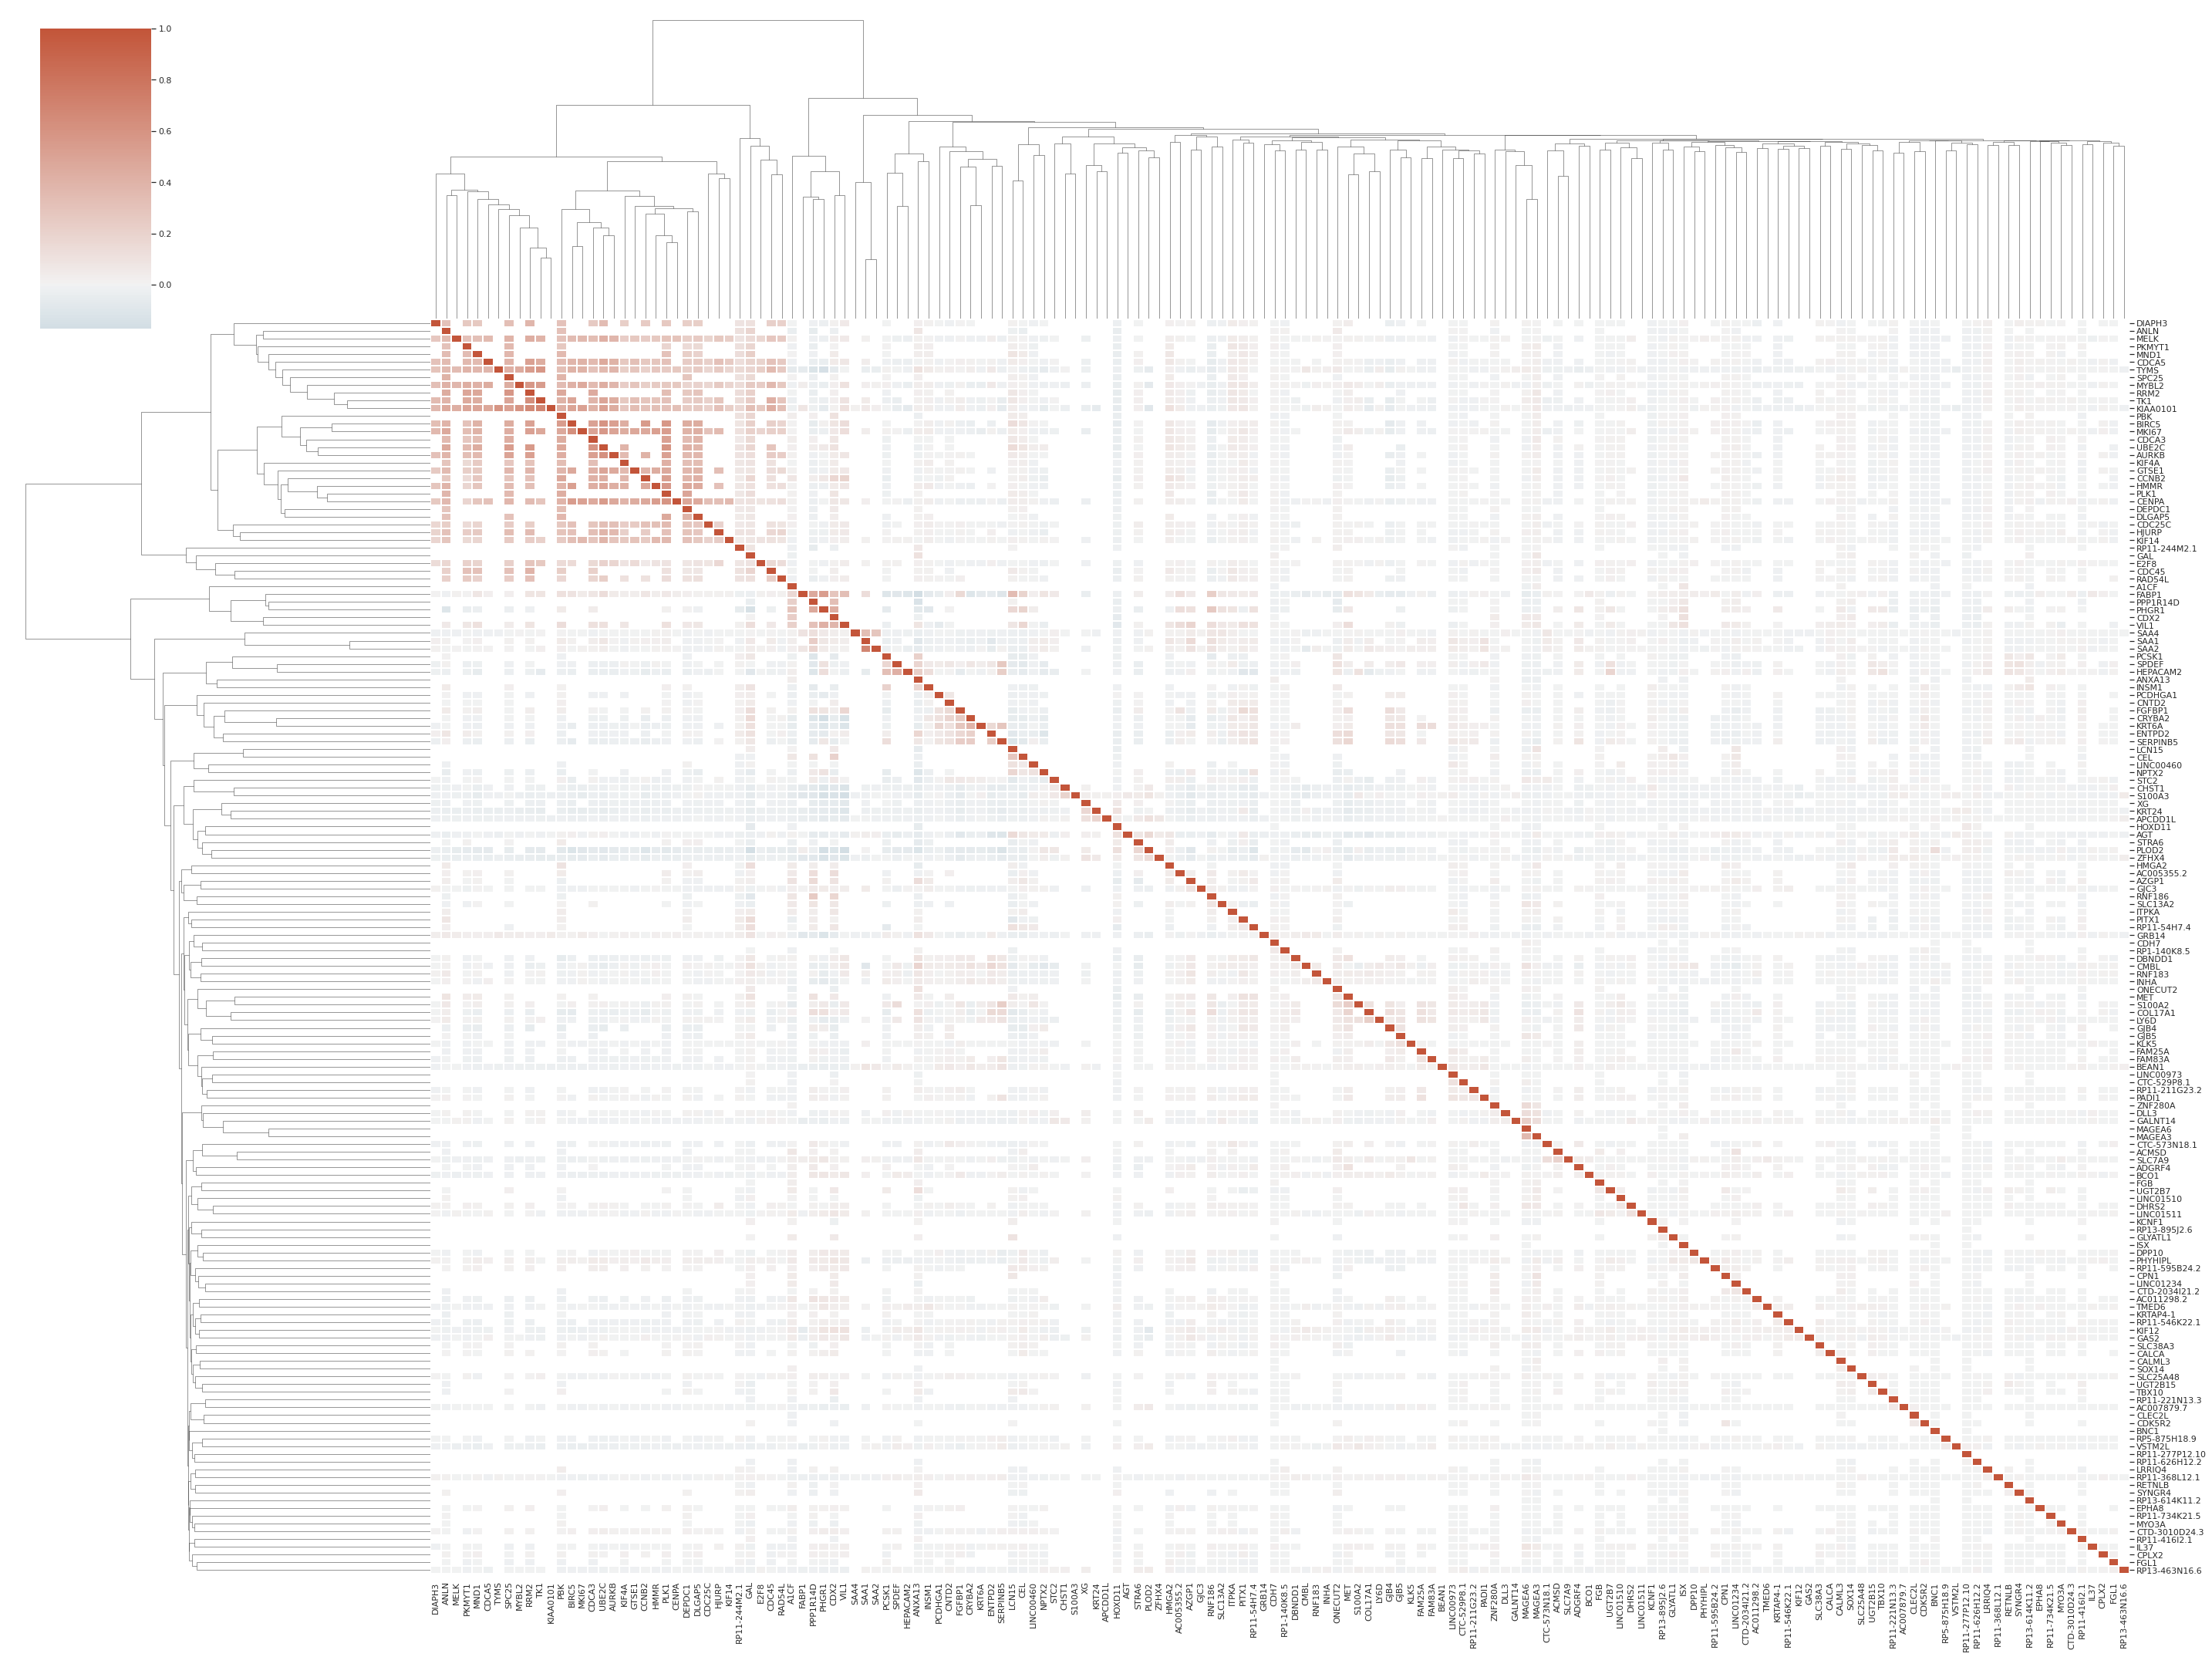

In [19]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.clustermap(corr, mask=mask, cmap=cmap, center=0, xticklabels=True, yticklabels=True,
                    figsize=(40,30), linewidths=.01, cbar_kws={"shrink": .1})

plt.savefig('F4_lee_correlation_tumor_genelist.pdf')

# Gene - gene expression correlation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from anndata import read_h5ad

sns.set_theme(style='whitegrid')

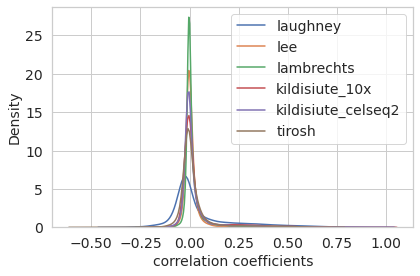

In [3]:
adatas = [
    read_h5ad('../data/laughney20_lung/adata.h5ad'),
    read_h5ad('../data/lee20_crc/adata.h5ad'),
    read_h5ad('../data/lambrechts18_lung/adata.h5ad'),
    read_h5ad("../data/kildisiute21_neuroblastoma_10x/adata.h5ad"),
    read_h5ad("../data/kildisiute21_neuroblastoma_celseq2/adata.h5ad"),
    read_h5ad("../data/tirosh17_headneck/adata.h5ad")
]
names = ['laughney', 'lee', 'lambrechts', 'kildisiute_10x', 'kildisiute_celseq2', 'tirosh']
plt.rcParams['figure.figsize'] = [6, 4]
for adata, name in zip(adatas, names):
    if name == 'laughney'or name == 'lee':
        idx_tum = adata.obs['tier_0_hallmark_corrected'] == 'Tumor'
    else:
        idx_tum = adata.obs['tier_0'] == 'Tumor'

    tgl_list = pd.read_csv('../out/signatures.gmt', sep="\t", header=None).iloc[1, 2:].dropna().tolist()

    df = adata[idx_tum].to_df()
    adata_genes_list = adata.var.iloc[:, 0].to_list()
    tgl_list = list(set(tgl_list) & set(adata_genes_list))

    df_selected = df.loc[:, tgl_list]

    corr = df_selected.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    masked_array = np.ma.masked_array(data=corr,mask=~mask)
    flatten_masked = masked_array.compressed()
    
    ax = sns.kdeplot(flatten_masked, label=name)
ax.set_xlabel('correlation coefficients')
ax.legend(fontsize=14)
for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(14)

plt.tight_layout()
plt.savefig(f"F4_gene_gene_expression_correlation.pdf")

# cell cycle genes ablation

In [ ]:
# cluster of correlated genes from above corresponds to cell cycle genes
cell_cycle_genes = [
    "DIAPH3",
    "ANLN",
    "MELK",
    "PKMYT1",
    "MND1",
    "CDCA5",
    "TYMS",
    "SPC25",
    "MYBL2",
    "RRM2",
    "TK1",
    "KIAA0101",
    "PBK",
    "BIRC5",
    "MKI67",
    "CDCA3",
    "UBE2C",
    "AURKB",
    "KIF4A",
    "GTSE1",
    "CCNB2",
    "HMMR",
    "PLK1",
    "CENPA",
    "DEPDC1",
    "DLGAP5",
    "CDC25C",
    "HJURP",
    "KIF14",
    "RP11-244M2.1",
    "GAL",
    "E2F8",
    "CDC45",
    "RAD54L"
]

In [1]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from pathlib import Path
import anndata

def plot_confusion_matrix(
    y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues, ax=None
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams['figure.figsize'] = [6, 4]
    # print(classes)
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred, labels=classes)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    if ax is None:
        (fig, ax) = plt.subplots()

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return fig, ax

In [2]:
paths = [
    Path("../out/lambrechts/"),
    Path("../out/kildisiute_10x/"),
    Path("../out/kildisiute_celseq2/")
]
names = [
    "lambrechts",
    "kildisiute_10x",
    "kildisiute_celseq2"
]

              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     45251
       Tumor       0.98      0.92      0.95      7447

    accuracy                           0.99     52698
   macro avg       0.98      0.96      0.97     52698
weighted avg       0.99      0.99      0.99     52698



/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'final_pred' as categorical
/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tier_0_pred_correctness' as categorical


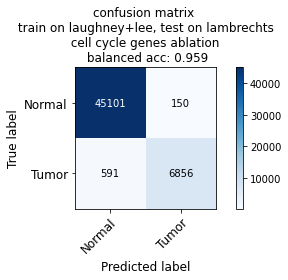

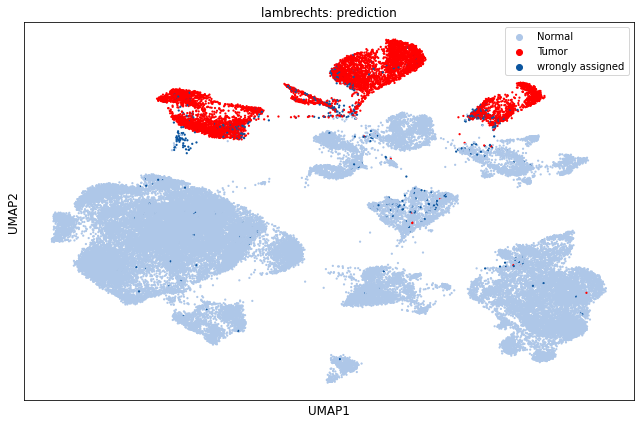

              precision    recall  f1-score   support

      Normal       0.77      1.00      0.87      4676
       Tumor       1.00      0.23      0.37      1766

    accuracy                           0.79      6442
   macro avg       0.89      0.62      0.62      6442
weighted avg       0.84      0.79      0.74      6442



/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'final_pred' as categorical
/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tier_0_pred_correctness' as categorical


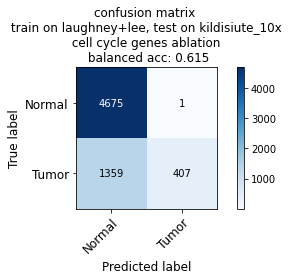

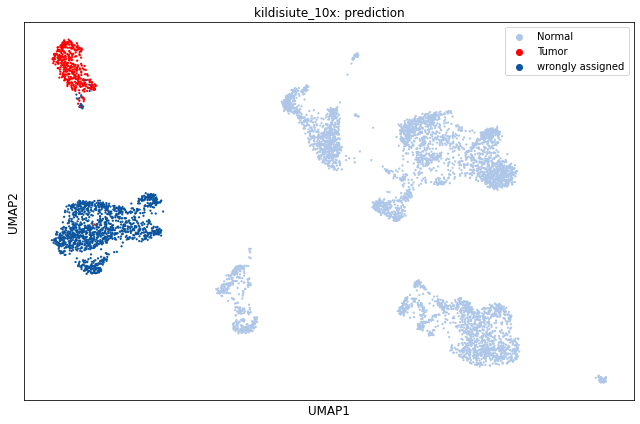

              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     11651
       Tumor       0.96      0.94      0.95      1630

    accuracy                           0.99     13281
   macro avg       0.98      0.97      0.97     13281
weighted avg       0.99      0.99      0.99     13281



/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'final_pred' as categorical
/home/jdohmen/.miniconda3/envs/ikarus-test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'tier_0_pred_correctness' as categorical


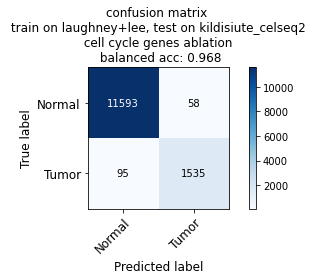

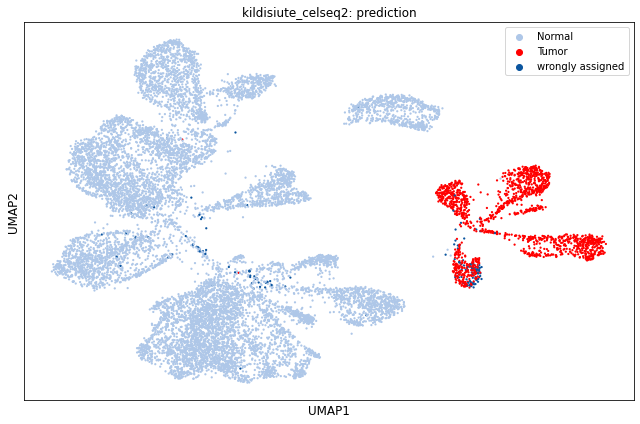

In [3]:
for path, name in zip(paths, names):
    results = pd.read_csv(f"../out/prediction_sensitivity_cell_cycle_ablation_{name}.csv", index_col=0)
    adata = anndata.read_h5ad(path / "adata_umap.h5ad")

    y = adata.obs.loc[:, 'tier_0']
    y_pred_lr = results['final_pred']
    acc = metrics.balanced_accuracy_score(y, y_pred_lr)
    print(metrics.classification_report(y, y_pred_lr, labels=['Normal', 'Tumor']))
    fig, ax = plot_confusion_matrix(
        y,
        y_pred_lr,
        classes=['Normal', 'Tumor'],
        title=f'confusion matrix \n train on laughney+lee, test on {name} \n cell cycle genes ablation \n balanced acc: {acc:.3f}',
    )
    fig.tight_layout()
    fig.savefig(f"F4_cell_cycle_genes_ablation_{name}_confusion_matrix.pdf")

    
    # umaps
    adata.obs[f"final_pred"] = results['final_pred'].values
    adata.obs.loc[:, 'tier_0_pred_correctness'] = 'wrongly assigned'
    adata.obs.loc[
        adata.obs['tier_0'] == adata.obs[f"final_pred"],
        'tier_0_pred_correctness'
    ] = 'correctly assigned'
    adata.obs.loc[:, 'tier_0_pred_wrong'] = pd.Categorical(
        adata.obs['tier_0'].copy(),
        categories=np.array(['Normal', 'Tumor', 'wrongly assigned']),
        ordered=True
    )
    adata.obs.loc[
        adata.obs['tier_0_pred_correctness'] == 'wrongly assigned',
        'tier_0_pred_wrong'
    ] = 'wrongly assigned'

    plt.rcParams['figure.figsize'] = [9, 6]

    colors = [
        ['tier_0_pred_wrong']
        ]
    titles = [
        [f'{name}: prediction']
        ]
    palettes = [
        ['#aec7e8', '#ff0000', '#0b559f'], 
    ]

    for color, title, palette, umap_type in zip(colors, titles, palettes, ["prediction"]):

        ax = sc.pl.umap(
            adata, ncols=1, size=20, 
            color=color,
            title=title,
            wspace=0.25,
            vmax='p99',
            legend_fontsize=12,
            palette=palette,
            show=False
        )
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(12)
        ax.legend(loc='best')
        plt.tight_layout()
        plt.savefig(f"F4_cell_cycle_genes_ablation_{name}_{umap_type}_umaps.pdf")
        plt.show()